In [1]:
import os
import sys  

import csv 
import cv2
import torch 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision.io import read_image
from six import raise_from
from tqdm import tqdm

from get_image_size import get_image_size
from engine import train_one_epoch, evaluate

import utils_vision 
import transforms as T 
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

sys.path.insert(0, "d:\\CAPSTONE\\mlcvnets")
from data import create_train_val_loader
from options.utils import load_config_file
from options.opts import get_training_arguments

from cvnets import get_model
from cvnets.models.detection import build_detection_model
from cvnets.models.classification import arguments_classification, build_classification_model

In [2]:
import sys
sys.argv=['']
del sys 
os.chdir("D:/CAPSTONE/mlcvnets")
os.getcwd()

'D:\\CAPSTONE\\mlcvnets'

In [3]:
from torch import nn, Tensor
from typing import Callable, Dict, List, Optional, Union

from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models._utils import handle_legacy_interface, IntermediateLayerGetter
class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x

In [4]:
from torch import nn
from typing import Callable, Dict, List, Optional, Union
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool


def _mobilevit_fpn_extractor(
    backbone,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
):
    
    layers_to_train = ["conv_1x1_exp", "layer_5", "layer_4", "layer_3", "layer_2", "layer_1", "conv_1"][:trainable_layers]
    for name, parameter in backbone.named_modules():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)
    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()
    if returned_layers is None: 
        returned_layers = [1,2,3,4,5]
    if min(returned_layers)<=0 or max(returned_layers)>=6:
        raise ValueError(f"Each returned layer should be in the range [1,5]. Got {returned_layers}")
    return_layers = {f"layer_{k}": str(v) for v,k in enumerate(returned_layers)}
    in_channels_list = []
    for layer in layers_to_train[::-1]:
        if layer.split('_')[0] == 'layer':
            in_channels_list.append(getattr(backbone, layer)[0].out_channels)
        else: in_channels_list.append(getattr(backbone, layer).out_channels)
    in_channels_list = in_channels_list[:-1]
    in_channels_list = in_channels_list[len(returned_layers)-1:]
    out_channels=256
    print("in_channels_list: ", in_channels_list)
    print("====> Done !")
    return BackboneWithFPN(backbone=backbone, return_layers=return_layers, in_channels_list=in_channels_list, out_channels=out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer)


In [5]:
opts = get_training_arguments()
setattr(opts, "common.config_file", "config/detection/ssd_mobilevitv3_xx_small_320.yaml")
opts = load_config_file(opts=opts)

setattr(opts, "model.detection.n_classes", 81)
setattr(opts, "dataset.workers", 0)

mobilevit = build_classification_model(opts=opts)

backbone = _mobilevit_fpn_extractor(backbone=mobilevit, trainable_layers=6, returned_layers=[1,2,3,4,5])

2023-09-28 19:35:02 - LOGS    - Pretrained weights are loaded from d:/CAPSTONE/mlcvnets/results/mobilevitv3_xx_small_e300_7098/run_1/checkpoint_ema_best.pt
in_channels_list:  [64, 80, 128]
====> Done !
{'layer_3': '0', 'layer_4': '1', 'layer_5': '2'}


In [11]:
mobilevit

MobileViTv3(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
  (layer_1): Sequential(
    (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
  )
  (layer_2): Sequential(
    (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
    (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
  )
  (layer_3): Sequential(
    (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
    (1): MobileViTv3Block(
    	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
    	patch_h=2, patch_w=2
    	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks=2
    )
  )
  (layer_4): Sequential(
    (0): InvertedResidual(in_ch

In [6]:
backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
    (layer_1): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
    )
    (layer_2): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
      (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    )
    (layer_3): Sequential(
      (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
      (1): MobileViTv3Block(
      	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
      	patch_h=2, patch_w=2
      	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks

In [7]:
img_demo = torch.rand(3,320,320)
img_tensor = img_demo.unsqueeze(0)

In [8]:
output = backbone(img_tensor)

In [10]:
for i in range(len(output)-1):
    print(output[str(i)].shape)
print(output['pool'].shape)

#torch.Size([1, 256, 40, 40])
#torch.Size([1, 256, 20, 20])
#torch.Size([1, 256, 10, 10])
#torch.Size([1, 256, 5, 5])
#torch.Size([1, 256, 3, 3])

torch.Size([1, 256, 40, 40])
torch.Size([1, 256, 20, 20])
torch.Size([1, 256, 10, 10])
torch.Size([1, 256, 5, 5])


In [5]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
def _default_anchorgen():
    anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [8,16,32,64])
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    return anchor_generator

In [6]:
_default_anchorgen()

((64, 80, 101), (128, 161, 203), (256, 322, 406), (512, 645, 812))
((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))


AnchorGenerator()

In [11]:
anchor_generator = _default_anchorgen()

In [12]:
anchor_generator(img_tensor, list(output.values()))

AttributeError: 'Tensor' object has no attribute 'tensors'

In [13]:
from torchvision.models.detection import RetinaNet

num_classes = 2
anchor_generator = _default_anchorgen()
model = RetinaNet(backbone=backbone, num_classes=num_classes, anchor_generator=anchor_generator)

In [14]:
model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
      (layer_1): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
      )
      (layer_2): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
        (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
        (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      )
      (layer_3): Sequential(
        (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
        (1): MobileViTv3Block(
        	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
        	patch_h=2, patch_w=2
        	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128

In [19]:
from torchvision.models.detection import retinanet_resnet50_fpn

retina = retinanet_resnet50_fpn(weights="DEFAULT")

{'layer2': '0', 'layer3': '1', 'layer4': '2'}


In [25]:
retina

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [20]:
out_retina = retina.backbone(img_demo)

In [23]:
out_retina

OrderedDict([('0',
              tensor([[[[ 0.2669,  0.3714,  0.4529,  ...,  0.5149,  0.4983,  0.2481],
                        [ 0.3170,  0.3082,  0.3808,  ...,  0.4702,  0.4688,  0.1620],
                        [ 0.3224,  0.3156,  0.3668,  ...,  0.4551,  0.4709,  0.1898],
                        ...,
                        [ 0.3002,  0.2753,  0.2793,  ...,  0.3728,  0.3469,  0.1172],
                        [ 0.3199,  0.3159,  0.3389,  ...,  0.3650,  0.3592,  0.1134],
                        [ 0.1154,  0.0862,  0.1057,  ...,  0.1913,  0.1766, -0.0024]],
              
                       [[ 0.3428,  0.6013,  0.4607,  ...,  0.4650,  0.4570,  0.2900],
                        [ 0.1090,  0.2818,  0.1688,  ...,  0.1379,  0.1496,  0.0767],
                        [ 0.1580,  0.3079,  0.2047,  ...,  0.1332,  0.1348,  0.0826],
                        ...,
                        [ 0.3526,  0.5419,  0.4203,  ...,  0.4260,  0.3853,  0.2463],
                        [ 0.3299,  0.5370,  0.4

In [24]:
for i in range(len(out_retina)-2):
    print(out_retina[str(i)].shape)
print(out_retina['p6'].shape)
print(out_retina['p7'].shape)

torch.Size([1, 256, 40, 40])
torch.Size([1, 256, 20, 20])
torch.Size([1, 256, 10, 10])
torch.Size([1, 256, 5, 5])
torch.Size([1, 256, 3, 3])


In [15]:
def _parse(value, function, fmt):
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)
def _open_for_csv(path):
    return open(path, 'r', newline='')
def get_image_metadata(file_path):
    size = os.path.getsize(file_path)
def _read_classes(csv_reader):
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1
        try:
            class_name, class_id = row
        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'class_name,class_id\''.format(line)), None)
        class_id = _parse(
            class_id, int, 'line {}: malformed class ID: {{}}'.format(line))

        if class_name in result:
            raise ValueError(
                'line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
        return result
def _read_images(base_dir):
    result = {}
    #dirs = [os.path.join(base_dir, o) for o in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, o))]
    dirs = [os.path.join(base_dir, 'images')]
    if len(dirs) == 0:
        dirs = ['']
    for project in dirs:
        project_imgs = os.listdir(os.path.join(base_dir, project))
        i = 0
        print("Loading images...")
        for image in tqdm(project_imgs):
            try:
                img_file = os.path.join(base_dir, project, image)
                exists = os.path.isfile(img_file)
                
                if not exists:
                    print("Warning: Image file {} is not existing".format(img_file))
                    continue
                # Image shape
                height, width = get_image_size(img_file)
                result[img_file] = {"width": width, "height": height}
                i += 1
            except Exception as e:
                print("Error: {} in image: {}".format(str(e), img_file))
                continue
    return result
def _read_annotations(csv_reader, classes, base_dir, image_existence):
    result = {}
    base_dir = os.path.join(base_dir, 'images')
    for line, row in enumerate(csv_reader):
        line += 1
        try: 
            img_file, x1, y1, x2, y2, class_name, width, height = row[:]
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            width = int(width)
            height = int(height)
            if x1 >= width:
                x1 = width - 1
            if x2 >= width:
                x2 = width - 1
            
            if y1 >= height:
                y1 = height - 1
            if y2 >= height:
                y2 = height - 1 
            # x1 < 0 | y1 < 0 | x2 <= 0 | y2 <= 0
            if x1<0 | y1<0 or x2<=0 or y2<=0:
                print("Warning: Image file {} has some bad boxes annotations".format(img_file))
                continue
            # Append root path 
            img_file = os.path.join(base_dir, img_file)
            # Check images exists 
            if img_file not in image_existence:
                print("Warning: Image file {} is not existing".format(img_file))
                continue                
        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''.format(line)),
                None)
        if img_file not in result:
            result[img_file] = []
        # If a row contains only an image path, it's an image without annotations.
        if (x1,x2,y1,y2,class_name) == ('', '', '', '', ''):
            continue
        x1 = _parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
        y1 = _parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
        x2 = _parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
        y2 = _parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))
        # Check that the bounding box is valid.
        if x2 <= x1:
            raise ValueError('line {}: x2 ({}) must be higher than x1 ({})'.format(line, x2, x1))
        if y2 <= y1:
            raise ValueError('line {}: y2 ({}) must be higher than y1 ({})'.format(line, y2, y1))
        # check if the current class name is correctly present
        if class_name not in classes:
            raise ValueError('line {}: unknown class name: \'{}\' (classes: {})'.format(line, class_name, classes))
        result[img_file].append({'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': class_name})
    return result

In [16]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], abs(box[2]-box[0]), abs(box[3]-box[1])
        rect = patches.Rectangle((x,y), width, height,
                                 linewidth=2, edgecolor = 'r', facecolor='none')
        a.add_patch(rect)
    plt.show()

def plot_img(img):
    fig, ax = plt.subplots(1,1)    
    ax.imshow(img)
    plt.show()


In [17]:
class CSVGenerator(torch.utils.data.Dataset):
    def __init__(self, csv_data_file, csv_class_file, width, height, base_dir=None, transform = None, **kwargs):
        self.image_names = []
        self.image_data = {}
        self.base_dir = base_dir
        self.transform = transform
        self.height = height
        self.width = width

        # __ delete __
        self.csv_data_file = csv_data_file
        self.csv_class_file = csv_class_file
        # __ delete __

        # Take base_dir from annotations file if not explicitly specified.
        if self.base_dir is None:
            self.base_dir = os.path.dirname(os.path.dirname(csv_data_file))

        # Parse the provided class file
        try:
            with _open_for_csv(csv_class_file) as file:
                self.classes = _read_classes(csv.reader(file, delimiter=','))
                # classes['object] = 0
        except ValueError as e:
            raise_from(ValueError(
                'invalid CSV class file: {}: {}'.format(csv_class_file, e)), None)

        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key  # labels[1] = object
            
        # build mappings for existence
        self.image_existence = _read_images(self.base_dir)
        
        # csv with img_path, x1, y1, x2, y2, class_name
        try:
            with _open_for_csv(csv_data_file) as file:
                self.image_data = _read_annotations(csv.reader(file, delimiter=','), self.classes, self.base_dir, self.image_existence)
        except ValueError as e: 
            raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(csv_data_file, e)), None)
        self.image_names = list(self.image_data.keys())
        
    def __getitem__(self, index):
        img_name = image_path = self.image_names[index]
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res = img_res/255.0
        boxes = []
        labels = []
        wt = img.shape[1]
        ht = img.shape[0]
        for row in self.image_data.get(img_name):
            #{'x1': 208, 'x2': 422, 'y1': 537, 'y2': 814, 'class': 'object'}
            x1, x2, y1, y2, class_name = row['x1'], row['x2'], row['y1'], row['y2'], row['class']
            labels.append(self.classes.get(class_name))
            xmin_corr = (x1/wt)*self.width
            xmax_corr = (x2/wt)*self.width
            ymin_corr = (y1/ht)*self.height
            ymax_corr = (y2/ht)*self.height
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.as_tensor([index])
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transform is not None:
            sample = self.transform(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']        
            target['boxes'] = torch.Tensor(sample['bboxes'])
        return img_res, target
       
    def __len__(self):
        return len(self.image_names)
        


In [18]:
train_generator = CSVGenerator(
    csv_data_file= os.path.abspath("../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048
)


Loading images...


100%|██████████| 11743/11743 [00:17<00:00, 655.04it/s]


KeyboardInterrupt: 

In [ ]:
print('length of dataset = {}'.format(len(train_generator)))

length of dataset = 8219


In [ ]:
img, target = train_generator[78]
print('length of dataset = {}'.format(len(train_generator)))
#print(img.shape, '\n', target)

length of dataset = 8219


In [ ]:
img_demo = torch.from_numpy(img).permute(2,0,1).unsqueeze_(0)

In [ ]:
img_demo.shape

torch.Size([1, 3, 224, 224])

In [ ]:
model(img_demo, [target])

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3010004928 bytes.

In [ ]:
#from torchvision.models.detection.retinanet import retinanet_resnet50_fpn

#retina = retinanet_resnet50_fpn(weights="DEFAULT")


{'layer2': '0', 'layer3': '1', 'layer4': '2'}


In [ ]:
retina(img_demo, [target])

{'classification': tensor(1.4323, grad_fn=<DivBackward0>),
 'bbox_regression': tensor(0.5875, grad_fn=<DivBackward0>)}

In [ ]:
exit()

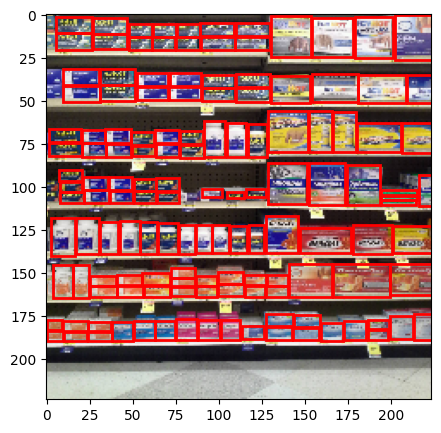

In [ ]:
img, target = train_generator[100]
plot_img_bbox(img, target)


In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [1]:
dataset = CSVGenerator(
    csv_data_file= os.path.abspath("../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=True)
)
dataset_test = CSVGenerator(
    csv_data_file= os.path.abspath("../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=False)
)

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, #num_workers=0,
    collate_fn=utils_vision.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, #num_workers=0,
    collate_fn=utils_vision.collate_fn)

NameError: name 'CSVGenerator' is not defined

In [ ]:
opts = get_training_arguments()
setattr(opts, "common.config_file", "config/detection/ssd_mobilevitv3_xx_small_320.yaml")
opts = load_config_file(opts=opts)

setattr(opts, "model.detection.n_classes", 81)
setattr(opts, "dataset.workers", 0)

for key, val in vars(opts).items():
    print(key, ":", val)

sampler.name : batch_sampler
sampler.bs.crop_size_width : 320
sampler.bs.crop_size_height : 320
sampler.vbs.crop_size_width : 256
sampler.vbs.crop_size_height : 256
sampler.vbs.min_crop_size_width : 160
sampler.vbs.max_crop_size_width : 320
sampler.vbs.min_crop_size_height : 160
sampler.vbs.max_crop_size_height : 320
sampler.vbs.max_n_scales : 5
sampler.vbs.check_scale : 32
sampler.vbs.ep_intervals : [40]
sampler.vbs.scale_inc_factor : 0.25
sampler.vbs.scale_inc : False
dataset.root_train : /datasets/coco_2014
dataset.root_val : /datasets/coco_2014
dataset.root_test : 
dataset.name : coco_ssd
dataset.category : detection
dataset.train_batch_size0 : 64
dataset.val_batch_size0 : 64
dataset.eval_batch_size0 : 1
dataset.workers : 0
dataset.persistent_workers : False
dataset.pin_memory : True
dataset.augmentation.gauss_noise_var : None
dataset.augmentation.jpeg_q_range : None
dataset.augmentation.gamma_corr_range : None
dataset.augmentation.blur_kernel_range : None
dataset.augmentation.tran

In [ ]:
mobilevit = build_classification_model(opts=opts)

2023-09-25 13:53:00 - LOGS    - Pretrained weights are loaded from d:/CAPSTONE/mlcvnets/results/mobilevitv3_xx_small_e300_7098/run_1/checkpoint_ema_best.pt


In [ ]:
#mobilevit = mobilevit.extract_features

In [ ]:
mobilevit

MobileViTv3(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
  (layer_1): Sequential(
    (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
  )
  (layer_2): Sequential(
    (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
    (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
  )
  (layer_3): Sequential(
    (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
    (1): MobileViTv3Block(
    	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
    	patch_h=2, patch_w=2
    	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks=2
    )
  )
  (layer_4): Sequential(
    (0): InvertedResidual(in_ch

In [ ]:
x = torch.rand(1,3,320,320)
mobilevit(x).shape

torch.Size([1, 1000])

In [ ]:
backbone = _mobilevit_fpn_extractor(backbone=mobilevit, trainable_layers=6, returned_layers=[3,4,5])

in_channels_list:  [16, 24, 64, 80, 128]
====> Done !
{'layer_3': '0', 'layer_4': '1', 'layer_5': '2'}


In [ ]:
backbone.eval()

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
    (layer_1): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
    )
    (layer_2): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
      (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    )
    (layer_3): Sequential(
      (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
      (1): MobileViTv3Block(
      	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
      	patch_h=2, patch_w=2
      	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks

In [ ]:
from torchvision.models.detection import RetinaNet

num_classes = 2
model = RetinaNet(backbone=backbone, num_classes=num_classes)

In [ ]:
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
      (layer_1): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
      )
      (layer_2): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
        (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
        (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      )
      (layer_3): Sequential(
        (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
        (1): MobileViTv3Block(
        	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
        	patch_h=2, patch_w=2
        	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128

In [ ]:
images, targets = next(iter(data_loader))

In [ ]:
images = list(image for image in images)


In [ ]:
targets = [{k:v for k,v in t.items()} for t in targets]


In [ ]:
output = model(images, targets)


RuntimeError: Given groups=1, weight of size [256, 24, 1, 1], expected input[8, 80, 50, 50] to have 24 channels, but got 80 channels instead

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model=model, optimizer=optimizer, data_loader=data_loader, device=device, epoch=epoch, print_freq=10)
    evaluate(model, data_loader_test, device=device)


KeyboardInterrupt

